## Natural Language Processing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
import nltk
#nltk.download_shell()

data from https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [353]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')] # white space stripped
len(messages)

5574

In [356]:
for spam_or_ham, message in enumerate(messages[:5]):
    print(spam_or_ham, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though


In [357]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysis

In [276]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


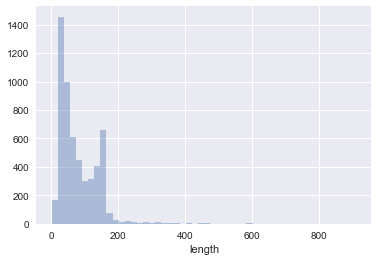

In [277]:
sns.distplot(messages['length'], kde=False, bins=50)
# or messages['length'].plot.hist(bins=50)
plt.show()

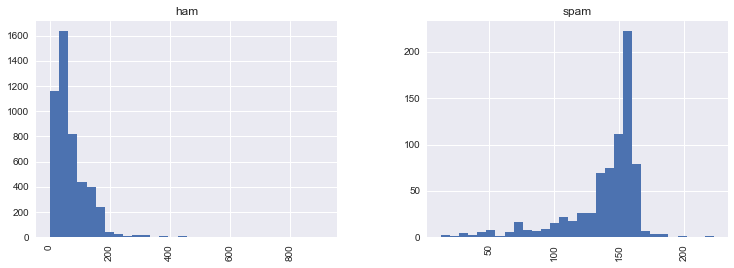

In [211]:
messages.hist(column='length', by='label', bins=30, figsize=(12, 4))
plt.show()

### Text Pre-processing

In [378]:
import string
from nltk.corpus import stopwords

mess = 'Simple Message! Notice: it has punctuation'
nopunc = ''.join([c for c in mess if c not in string.punctuation]) # 'Simple Message Notice it has punctuation'
nopunc = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] # delete 'it' and 'has'
nopunc

['Simple', 'Message', 'Notice', 'punctuation']

In [213]:
def text_process(mess): # remove punc/stop words, return list of clean text words
    nopunc = ''.join([char for char in mess if char not in string.punctuation])
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [379]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Vectorization

In [380]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
print('There are {} unique words.'.format(len(bow_transformer.vocabulary_)))

There are 11425 unique words.


In [388]:
mess4 = messages['message'][3]
print('Fourth message: ', mess4)
bow4 = bow_transformer.transform([mess4])
print(bow4)

Fourth message:  U dun say so early hor... U c already then say...
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [298]:
print(bow_transformer.get_feature_names()[4068]) # 'U' is repeated twice
print(bow_transformer.get_feature_names()[9554]) # 'say' is repeated twice

U
say


<font color='blue'>Transform all messages into bag-of-words</font>

In [230]:
messages_bow = bow_transformer.transform(messages['message'])

In [394]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format((sparsity))) # weight value for each of these words

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
sparsity: 0.07940295412668218


#### After the counting, the weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [220]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [231]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


<font color='blue'>Transform all bag-of-words corpus into TF-IDF corpus</font>

In [395]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

## Training a model

With messages represented as vectors, we can train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier)  classifier algorithm is a good choice.

In [223]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [224]:
print('Prediction: ', spam_detect_model.predict(tfidf4)[0])    # predict if 4th message is ham/spam
print('Actual: ', messages['label'][3])    # actual ham/smap label of 4th message

Prediction:  ham
Actual:  ham


In [227]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)
print('\n')

from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))  # actual label against predicted label

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



We evaluated accuracy on the same data we used for training. **However, You should never actually evaluate on the same dataset you train on!** Such evaluation tells us nothing about the true predictive power of our model. 

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [228]:
from sklearn.cross_validation import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.3)

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [392]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to bow (integer counts)
    ('tfidf', TfidfTransformer()),  # bow into TF-IDF scores
    ('classifier', MultinomialNB())  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(msg_train, label_train)
predictions = pipeline.predict(msg_test)

In [320]:
from sklearn.metrics import classification_report
print(classification_report(predictions, label_test)) 

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1514
       spam       0.71      1.00      0.83       158

avg / total       0.97      0.96      0.96      1672



## Test New Messages

In [337]:
def test_ham_or_spam(message):
    bowNewMess = bow_transformer.transform([message]) # turns new message into bag of words
    tfidfNewMess = tfidf_transformer.transform(bowNewMess)
    print('Prediction: ', spam_detect_model.predict(tfidfNewMess)[0])

In [350]:
newMess1 = messages['message'][10]
test_ham_or_spam(newMess1)

Prediction:  ham


In [374]:
newMess2 = 'Due to a new legislation, those struggling with debt can now apply to have it written off. For more information text the word INFO or to opt out text STOP'
test_ham_or_spam(newMess2)

Prediction:  spam


In [375]:
newMess3 = 'IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out.'
test_ham_or_spam(newMess3)

Prediction:  spam


In [376]:
newMess4 = 'Hi! I will be there in 10 minutes, running late because of traffic'
test_ham_or_spam(newMess4)

Prediction:  ham
